In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# CONSTANTS

cone_model = np.array([
    [0.0,  0.0,     0.325], #K1
    [0.0, -0.038,   0.217], #K2
    [0.0,  0.038,   0.217], #K3
    [0.0, -0.076,   0.108], #K4
    [0.0,  0.076,   0.108], #K5
    [0.0, -0.114,   0.0],   #K6
    [0.0,  0.114,   0.0],   #K7
], dtype = "double")

## for testing (must to camera calibration)
im = cv2.imread(glob('data/example_sequence/*.jpg')[0])
size = im.shape
center = (size[1]/2, size[0]/2)
## end for testing


focal_length = center[0] / np.tan(60/2 * np.pi / 180)
camera_matrix = np.array(
     [[focal_length, 0, center[0]],
     [0, focal_length, center[1]],
     [0, 0, 1]], dtype = "double"
     )
dist_coeffs = np.zeros((4,1))

In [3]:
net = cv2.dnn.readNet('data/yolov4-tiny_608-3l_dv_final.weights', "data/yolov4-tiny_608-3l_dv.cfg")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(608, 608), scale=1/255)

In [4]:
kmodel = rt.InferenceSession("data/rektnet.onnx")
kinput_name = kmodel.get_inputs()[0].name
klabel_name = kmodel.get_outputs()[0].name

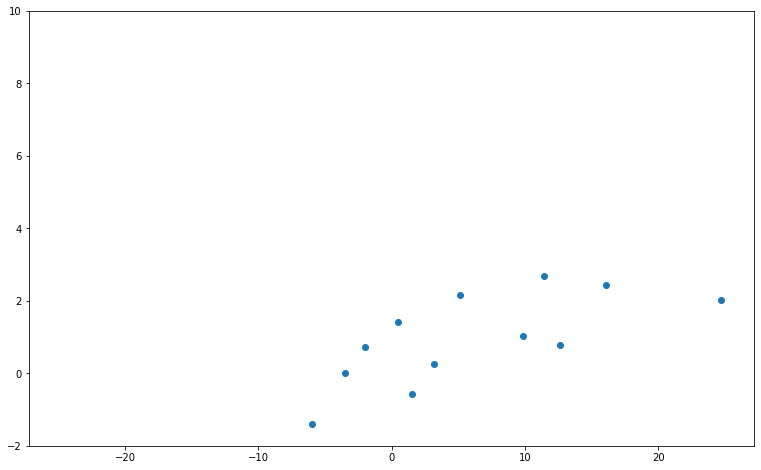

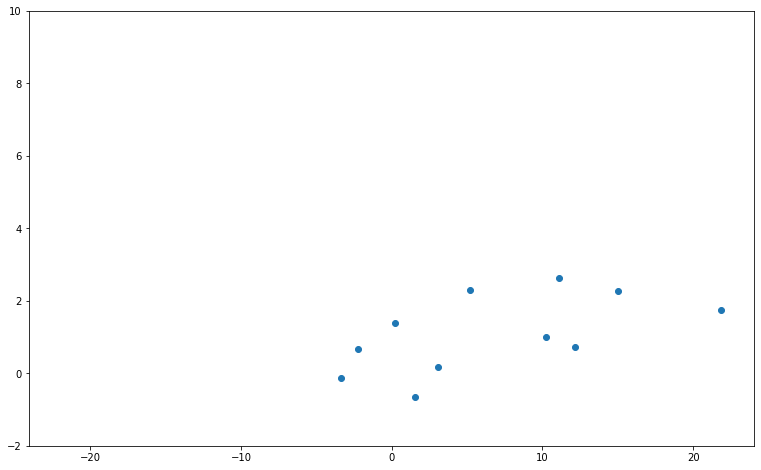

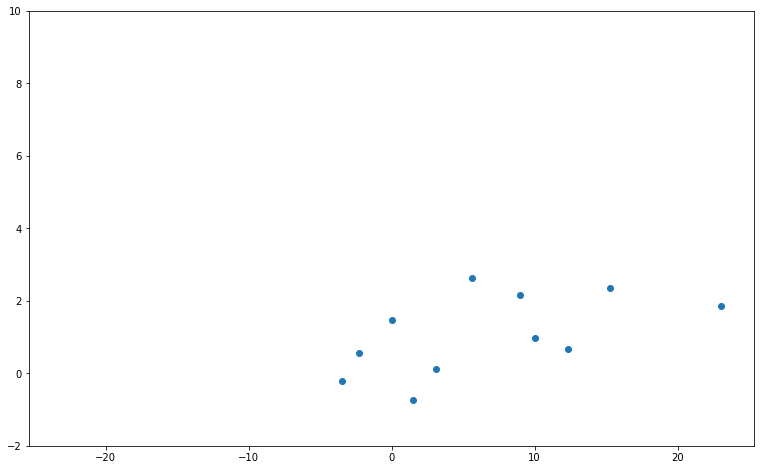

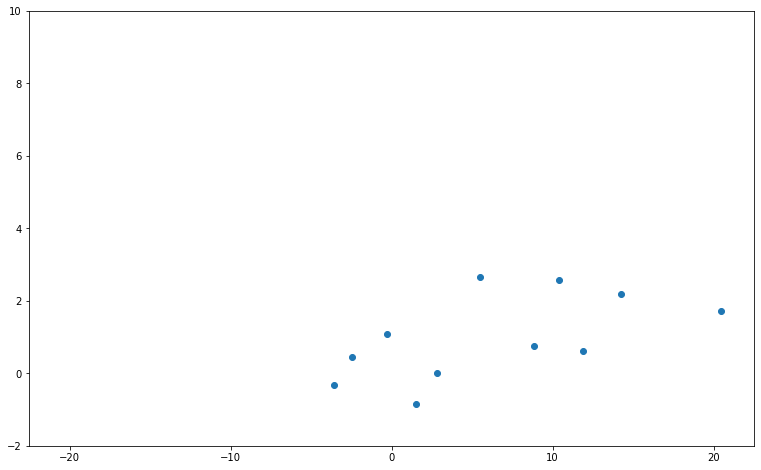

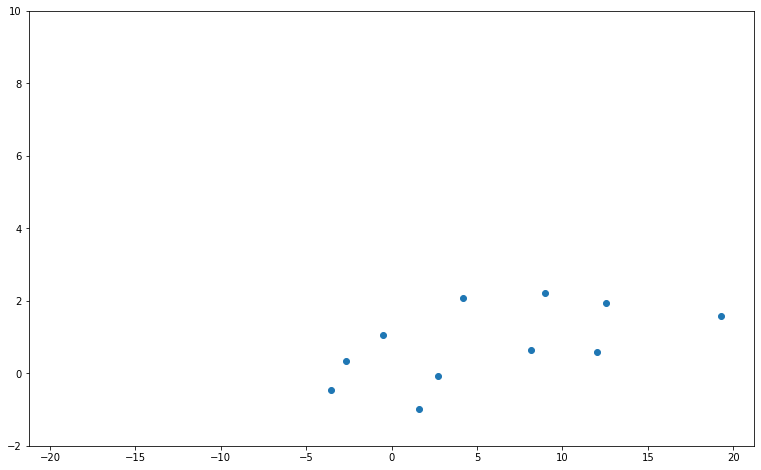

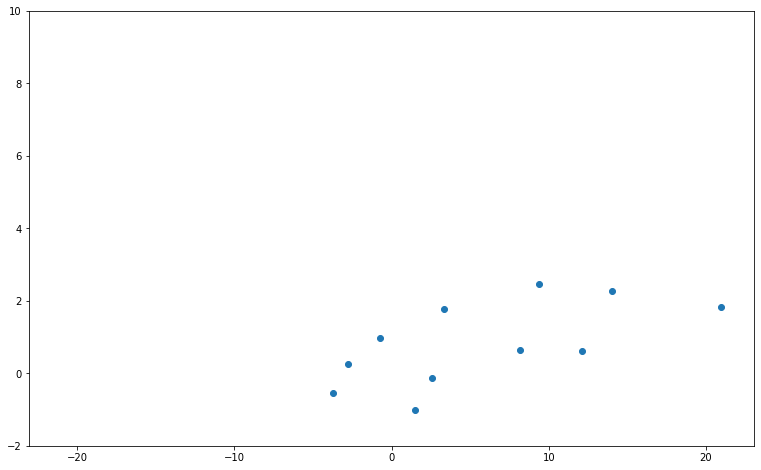

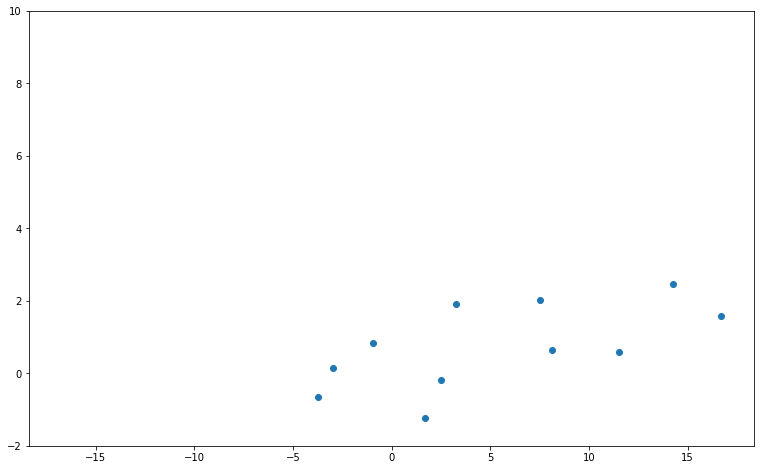

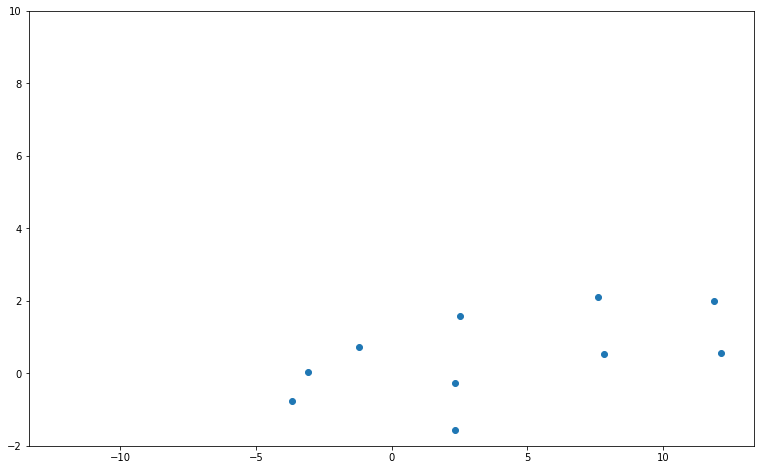

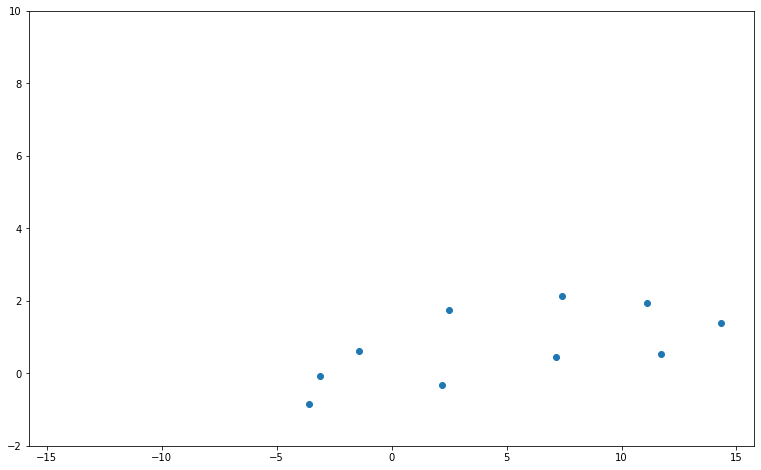

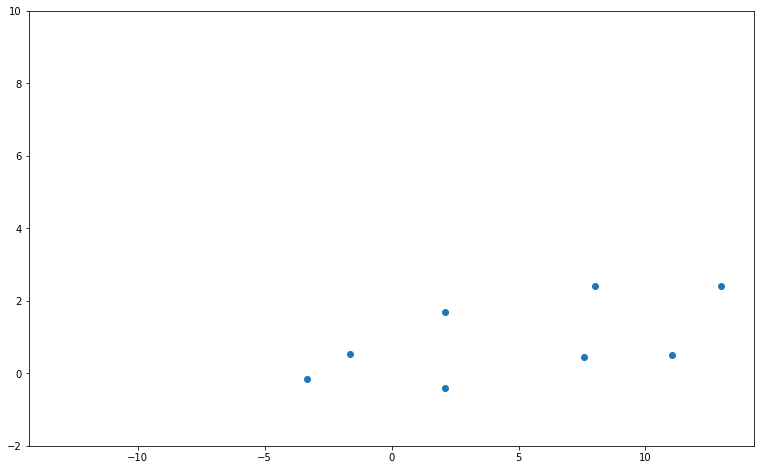

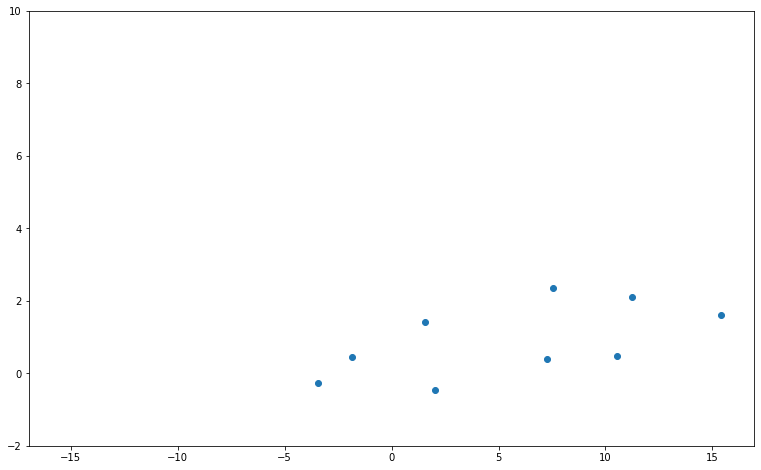

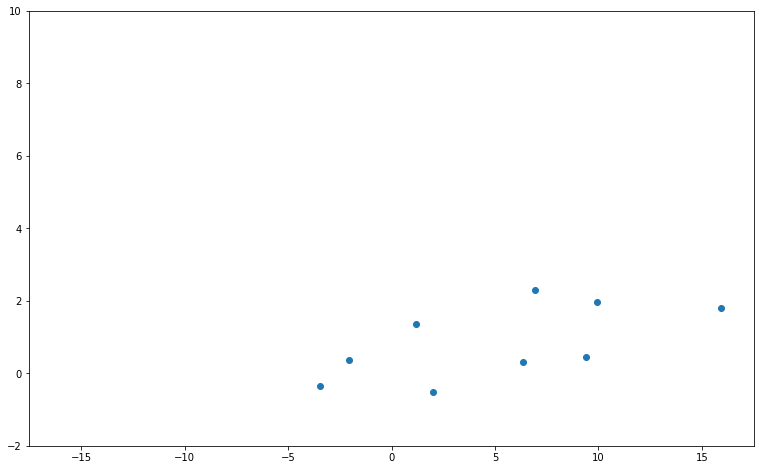

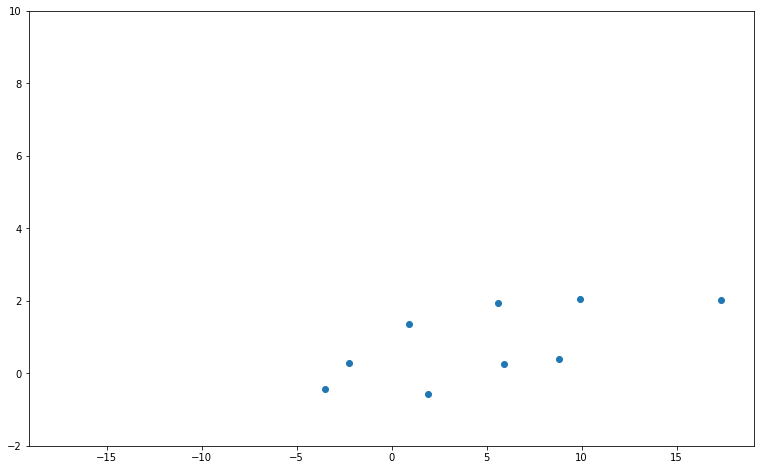

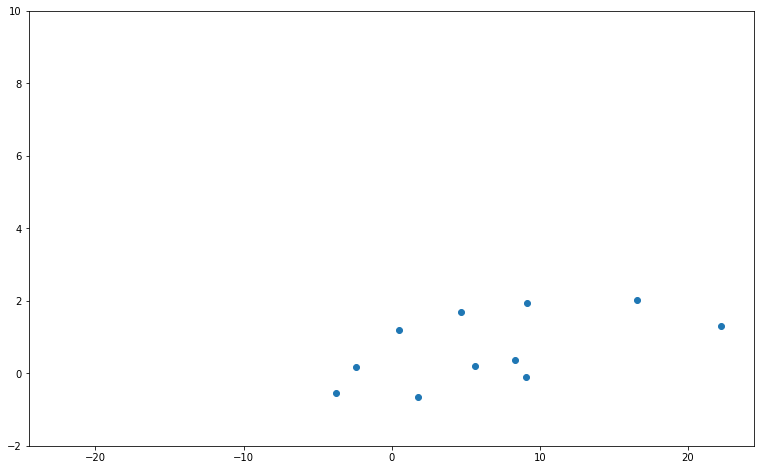

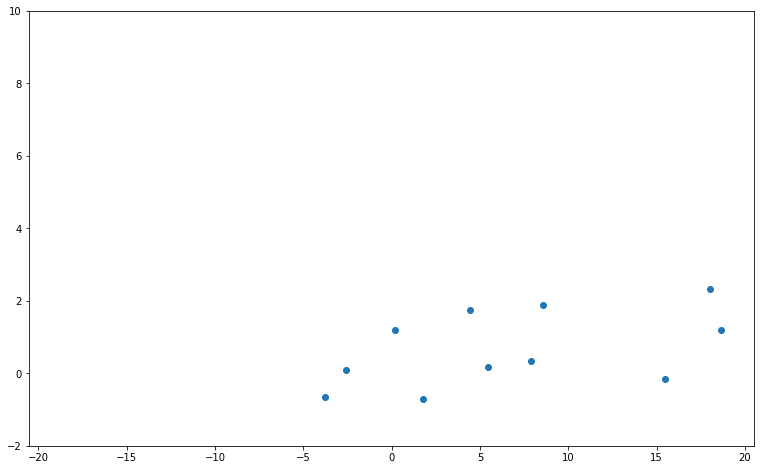

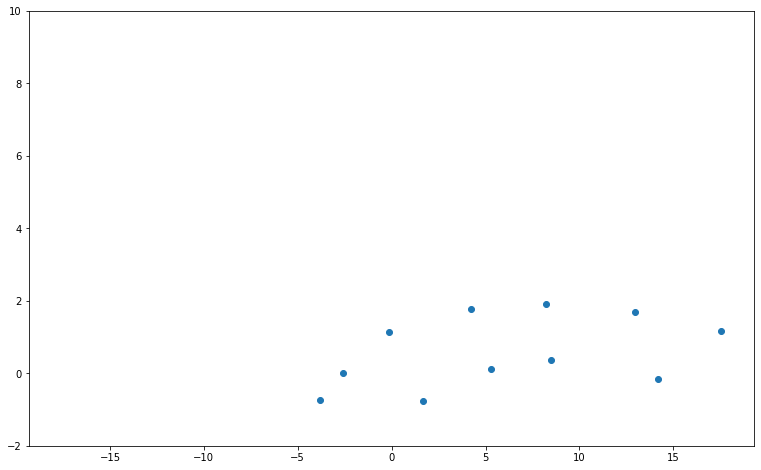

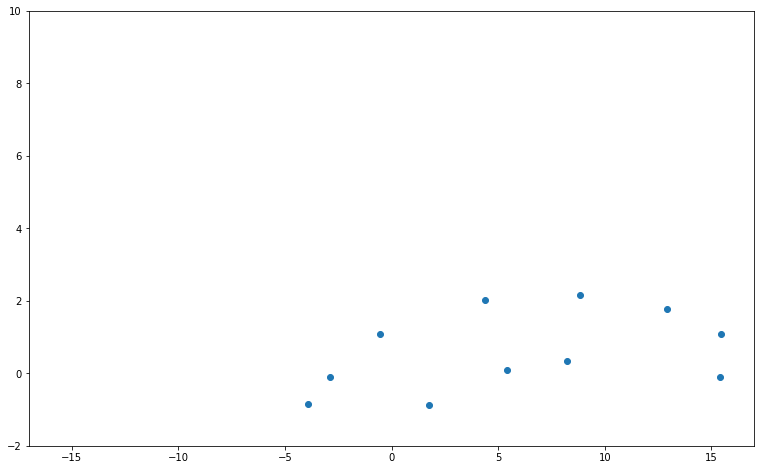

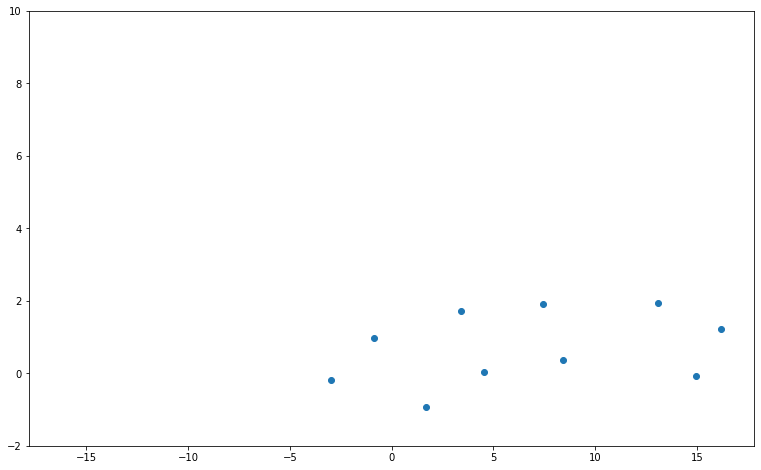

In [11]:
for img_path in sorted(glob('data/example_sequence/*.jpg')):
    im = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    classes, scores, boxes = model.detect(im, 0.2, 0.4)
    boxes = np.array(boxes)
    
    cones = np.empty((boxes.shape[0],3,80,80), np.float32)
    sizes = np.empty((boxes.shape[0],2))
    for i, (x,y,w,h) in enumerate(boxes):
        cones[i] = cv2.resize(im[y:y+h, x:x+w], (80, 80)).transpose((2, 0, 1)) * 1./255.0
        sizes[i] = [w,h]
    
    keypoints = kmodel.run([klabel_name], {kinput_name: cones})[0].astype('double')
    keypoints *= sizes.reshape(-1, 1, 2)
    keypoints += boxes[:, :2].reshape(-1, 1, 2)
    
    tvecs = []
    for key in keypoints:
        tvec = cv2.solvePnP(
                objectPoints = cone_model,
                imagePoints = key,
                cameraMatrix = camera_matrix, 
                distCoeffs = dist_coeffs,
                flags=cv2.SOLVEPNP_ITERATIVE
            )[2]

        tvecs.append(tvec)
        
    tvecs = np.array(tvecs)
    
    fig = plt.figure(figsize=(13,8))
    plt.scatter(tvecs[:,0], np.negative(tvecs[:,1]))

    plt.xlim(*(np.max(np.abs(tvecs[:,0])*1.1)*np.array([-1,1])))
    plt.ylim(-2, 10)
    plt.show()
    
    break